In [1]:
import sys
sys.path.append("..")

In [2]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample, PyroParam

from modules.config import read_config
from modules.datageneration import load_data, data_functions

from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader

import tyxe
pyro.set_rng_seed(42)

In [3]:
x1 = torch.rand(20, 1) * 0.7 - 1.8
x2 = torch.rand(10, 1) * 0.8 + 2.2
x = torch.cat([x1, x2])
sigma = 0.3
noise = torch.normal(mean=torch.full_like(x, 0.), std=sigma)
y = x.mul(1.5).add(0.2).sin().mul(1.5) + noise

x_test = torch.linspace(-4, 4, 401).unsqueeze(-1)

y_test = x_test.mul(1.5).add(0.2).sin().mul(1.5)

In [4]:
x.shape, y.shape

(torch.Size([30, 1]), torch.Size([30, 1]))

In [5]:
dataset = data.TensorDataset(x, y)
loader = data.DataLoader(dataset, batch_size=len(x))

In [6]:
x1, y1 = next(iter(loader))

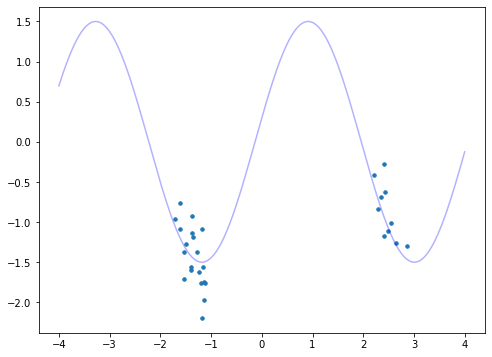

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x.squeeze(), y, s=12)
plt.plot(x_test.squeeze(), y_test, color="blue", alpha=0.3)

In [8]:
net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 1))
optim = torch.optim.Adam(net.parameters(), 1e-4)
for _ in range(20000):
    optim.zero_grad()
    net(x).sub(y).pow(2).mean().backward()
    optim.step()

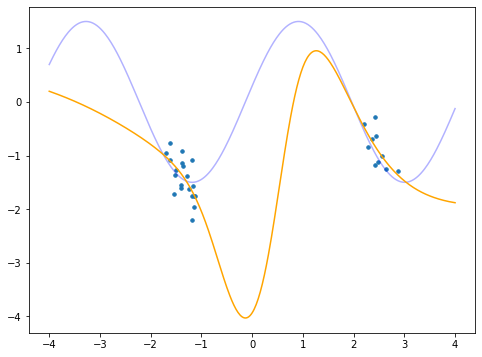

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x.squeeze(), y, s=12)
plt.plot(x_test.squeeze(), y_test, color="blue", alpha=0.3)
plt.plot(x_test, net(x_test).detach(), color="orange")


In [10]:
net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 1))

In [11]:
prior = tyxe.priors.IIDPrior(dist.Normal(0, 3))

In [12]:
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale=0.05)

In [13]:
guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)

In [14]:
bnn = tyxe.VariationalBNN(net, prior, obs_model, guide_builder)

In [15]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
elbos = []
def callback(bnn, i, e):
    if i % 1000 == 0:
        print("epoch: {} | elbo: {}".format(i, e))
    elbos.append(e)

with tyxe.poutine.local_reparameterization():
    bnn.fit(loader, optim, 20000, callback)

epoch: 0 | elbo: 879.8553466796875
epoch: 1000 | elbo: 608.6473999023438
epoch: 2000 | elbo: 457.755615234375
epoch: 3000 | elbo: 323.1986083984375
epoch: 4000 | elbo: 230.44845581054688
epoch: 5000 | elbo: 166.8874053955078
epoch: 6000 | elbo: 149.0233612060547
epoch: 7000 | elbo: 145.1529998779297
epoch: 8000 | elbo: 157.08529663085938
epoch: 9000 | elbo: 147.89596557617188
epoch: 10000 | elbo: 149.24301147460938
epoch: 11000 | elbo: 144.25537109375
epoch: 12000 | elbo: 151.0438232421875
epoch: 13000 | elbo: 138.91580200195312
epoch: 14000 | elbo: 139.05364990234375
epoch: 15000 | elbo: 153.210205078125
epoch: 16000 | elbo: 142.0050048828125
epoch: 17000 | elbo: 150.57623291015625
epoch: 18000 | elbo: 161.07205200195312
epoch: 19000 | elbo: 137.93594360351562


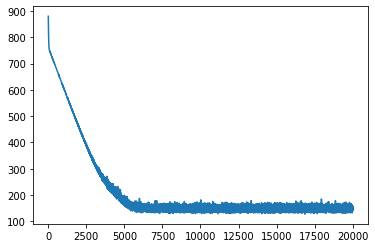

In [16]:
plt.plot(elbos)

In [17]:
m, sd = bnn.predict(x_test, num_predictions=50)

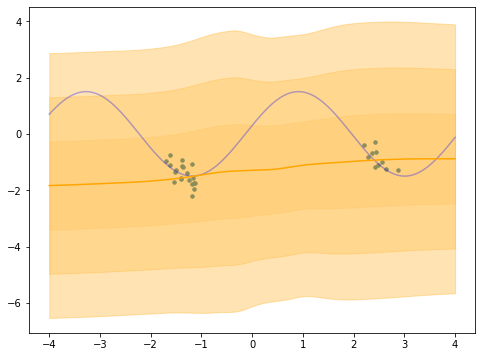

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x.squeeze(), y, s=12)
plt.plot(x_test.squeeze(), y_test, color="blue", alpha=0.3)
plt.plot(x_test, m.detach(), color="orange")
for c in range(1, 4):
    plt.fill_between(x_test.squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="orange")

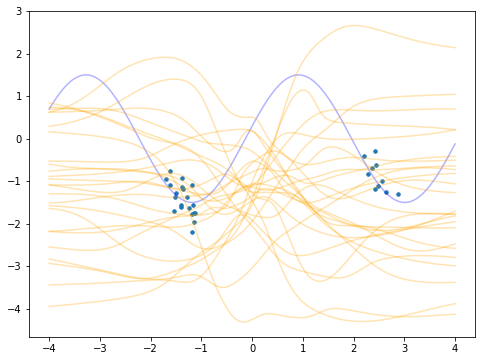

In [19]:

sampled_predictions = bnn.predict(x_test, num_predictions=25, aggregate=False)

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x.squeeze(), y, s=12)
plt.plot(x_test.squeeze(), y_test, color="blue", alpha=0.3)
for yhat in sampled_predictions:
    plt.plot(x_test, yhat, color="orange", alpha=0.3)

In [20]:
net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 1))
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale=PyroParam(torch.tensor(0.05)))
guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
bnn = tyxe.VariationalBNN(net, prior, obs_model, guide_builder)

In [21]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
elbos = []
def callback(bnn, i, e):
    if i % 1000 == 0:
        print("epoch: {} | elbo: {}".format(i, e))
    elbos.append(e)

with tyxe.poutine.local_reparameterization():
    bnn.fit(loader, optim, 20000, callback)

epoch: 0 | elbo: 15893.453125
epoch: 1000 | elbo: 574.8303833007812
epoch: 2000 | elbo: 414.57342529296875
epoch: 3000 | elbo: 381.75164794921875
epoch: 4000 | elbo: 284.01995849609375
epoch: 5000 | elbo: 221.07421875


KeyboardInterrupt: 

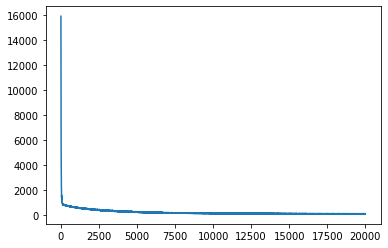

In [ ]:
plt.plot(elbos)

In [ ]:
m, sd = bnn.predict(x_test, num_predictions=50)
m, sd = m.detach(), sd.detach()

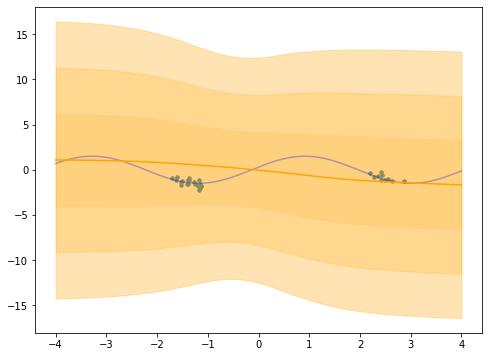

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x.squeeze(), y, s=12)
plt.plot(x_test.squeeze(), y_test, color="blue", alpha=0.3)
plt.plot(x_test, m.detach(), color="orange")
for c in range(1, 4):
    plt.fill_between(x_test.squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="orange")